In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv 
from datetime import timedelta, datetime, date


from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.enums import Adjustment
from alpaca.data.timeframe import TimeFrame

In [2]:
%matplotlib inline

# Summary

### Goal:
- explore congress trades dataset and visualize key information 

## Utilities

In [3]:
def plot_group_counts(df: pd.DataFrame, column: str, rotation=0):
    """
    Groups the DataFrame by the specified column and plots the count of each group.
    """
    # Group by the specified column and count the occurrences
    group_counts = df.groupby(column).size()


    # Plotting
    plt.bar(group_counts.index,group_counts)
    plt.xlabel(column)
    plt.xticks(rotation=rotation, ha="right")
    plt.ylabel('Counts')
    plt.title(f'Count of each group in {column}')
    plt.show()
    return plt

## Load Data

In [4]:
congress_trades_df = pd.read_csv("../data/congress_trades_all.csv")
congress_trades_df.rename(columns={"Representative": "name"}, inplace=True)
congress_trades_df[["TransactionDate","ReportDate"]] = \
    congress_trades_df[["TransactionDate","ReportDate"]].apply(pd.to_datetime)

congress_trades_df["TimeToReport"] = congress_trades_df["ReportDate"] - congress_trades_df["TransactionDate"]
print(congress_trades_df.info())

congress_trades_df['name'] = congress_trades_df['name'].apply(lambda x: x.strip())

print(f"First transaction: {congress_trades_df['TransactionDate'].min()}")
print(f"Last transaction: {congress_trades_df['TransactionDate'].max()}")

print(f'Unique Tickers Traded: {len(congress_trades_df["Ticker"].unique())}')
print(f'QTY Congress People: {len(congress_trades_df["name"].unique())}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22620 entries, 0 to 22619
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   ReportDate       22261 non-null  datetime64[ns] 
 1   TransactionDate  22620 non-null  datetime64[ns] 
 2   Ticker           22620 non-null  object         
 3   name             22620 non-null  object         
 4   Transaction      22620 non-null  object         
 5   Amount           22620 non-null  float64        
 6   House            22620 non-null  object         
 7   Range            22620 non-null  object         
 8   TimeToReport     22261 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 1.6+ MB
None
First transaction: 2014-07-25 00:00:00
Last transaction: 2023-03-03 00:00:00
Unique Tickers Traded: 1585
QTY Congress People: 212


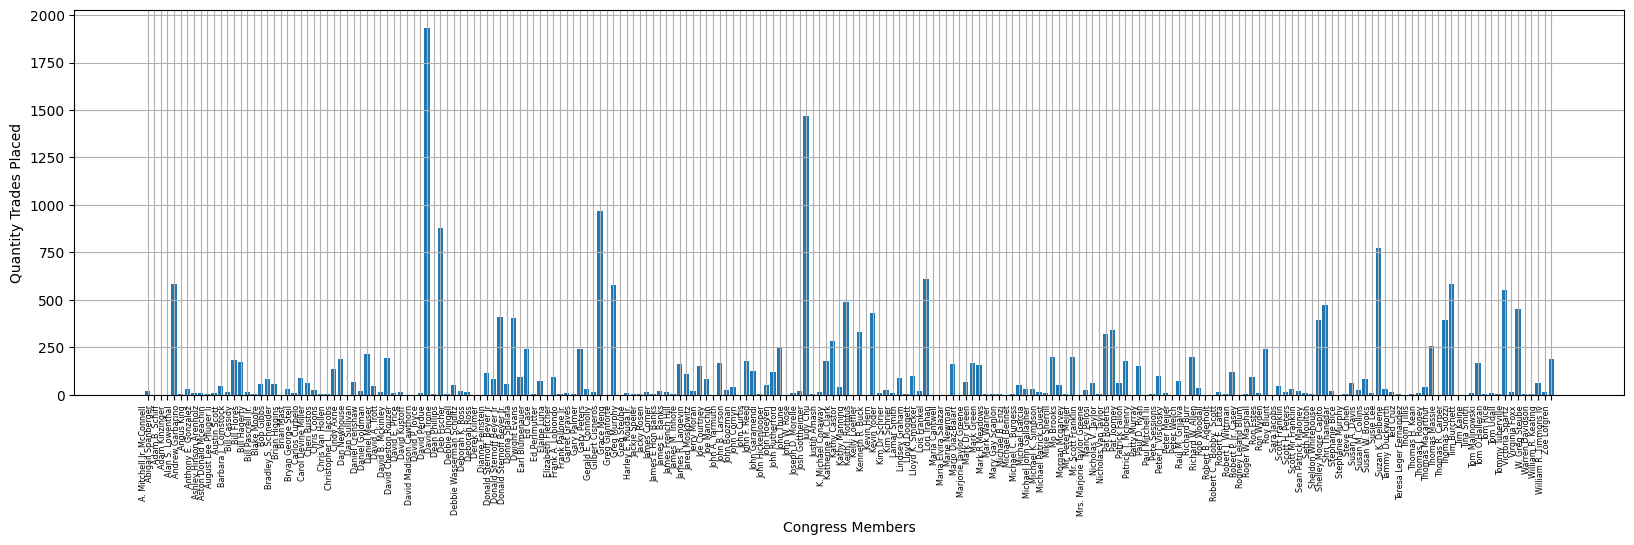

In [5]:
#examine trade quantity of congress people

grouped_df = congress_trades_df.groupby("name").size()


plt.figure(figsize=(20, 5))
plt.bar(grouped_df.index, grouped_df)
plt.xlabel("Congress Members")
plt.ylabel("Quantity Trades Placed")
plt.xticks(rotation=90,ha="right",size="xx-small")
plt.grid()
plt.show()


## Examine Time to Report Transactions

<Axes: ylabel='Frequency'>

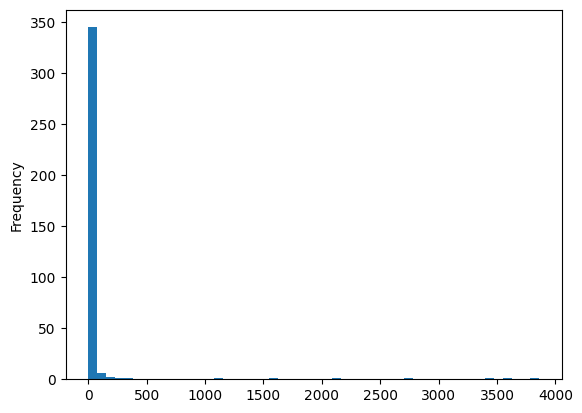

In [6]:

grouped_df = congress_trades_df.groupby(pd.Grouper(key="TimeToReport",freq="7D")).size()
grouped_df.plot.hist(bins=50)


## Stock Act Violations
### (Reported a trade after the 45day period mandated in stock act)

In [7]:
# stock act requires all trades to be reported within 45 days of transaction.. 
# lets see who violated this 
violating_trades_df = congress_trades_df[congress_trades_df["TimeToReport"]> pd.Timedelta(days=45)]
violating_trades_df.head()
violators = violating_trades_df["name"].unique()
members = congress_trades_df["name"].unique()
percent_violated = round(len(violators)/len(members)*100,1)
print(f"{len(violators)} out of {len(members)} stock-trading Congress members ({percent_violated}%) violated the stock act")


violators_grouped = pd.DataFrame({"ViolatingTrades": violating_trades_df.groupby("name").size() }).reset_index()
print(violators_grouped.sort_values(by="ViolatingTrades",ascending=False).head(10))

119 out of 212 stock-trading Congress members (56.1%) violated the stock act
                     name  ViolatingTrades
107         Thomas Suozzi              539
25           David Perdue              427
31          Donna Shalala              394
55        Josh Gottheimer              231
36            Gary Palmer              192
99              Susie Lee              172
109        Tom Malinowski              156
57     Katherine M. Clark              140
18             Cindy Axne              139
95   Shelley Moore Capito              139


## Examine Trade Size of Congress Members

In [8]:
congress_trades_df["Range"].unique()

array(['$1,001-$15,000', '$50,001-$100,000', '$15,001-$50,000',
       '$1,001 - $15,000', '$15,001 - $50,000', '$250,001-$1,000,000',
       '$100,001-250,000', '$50,001 - $100,000', '$328.23',
       '$100,001 - $250,000', '$439.25', '$743.62', '$387.85', '$348.94',
       '$251.68', '$629.20', '$572.16', '$581.15', '$805.35', '$120.74',
       '$241.50', '$120.44', '$120.43', '$126.40', '$251.04', '$231.65',
       '$610.44', '$998.90', '$146.65', '$342.19', '$996.91', '$474.72',
       '$250,001 - $500,000', '$344.01', '$691.36', '$835.94', '$390.10',
       '$331.46', '$718.16', '$99.83', '$500,001', '$.01', '$257.45',
       '$369.93', '$669.93', '$500,001-$1,000,000', '$250,001-$500,000',
       '$336.91', '$500,001 - $1,000,000', '$100,001-$250,000',
       '$1,000,001-$5,000,000', '$440.78', '$686.21', '$762.12',
       '$757.25', '$681.76', '$767.05', '$47.11', '$224.01', '$4,450.50',
       '$997.95', '$1.00', '$898.16', '$90.00', '$754.23', '$120.67',
       '$30.16', '$60.

In [9]:
# lets look at trade size of congress members

range_before = congress_trades_df["Range"].unique()
print(f"Initial Length of Unique Congress Trade Ranges: {len(range_before)}")
## clean up Range columns so all outptus are bucketd in same format
replacements = [
         ("$",""),
         (",","")
    ]

range_identifiers = [
     "-",
     "<",
     ">"
]

def replace_values(x, replacements):
    for old,new in replacements:
         x = x.replace(old,new)
    return x

def check_if_range(x, range_identifiers):
     for character in range_identifiers:
          if character in x:
               return True
     else:
        return False

# print(convert_dollar_to_float("$123.23"))
def bucket_trades_under_1000(x):
        value = float(replace_values(x,replacements))
        if value < 1001:
            return "<$1001"
        
def extract_integers_from_range(x):
     x_clean = replace_values(x,replacements)
     return [int(num) for num in x_clean.split("-")]

print(extract_integers_from_range("$1,001-15,000"))

        
def convert_ranges_to_uniform_format(x):
    if x is None:
         return None
    #handle case for individual stocks under $1000
    if not check_if_range(x, range_identifiers):
        return bucket_trades_under_1000(x)
    if "-" in x:
         int1,int2 = extract_integers_from_range(x)
         return f"${int1}-${int2}"
    

congress_trades_df["Range"] = congress_trades_df["Range"].apply(lambda range: convert_ranges_to_uniform_format(range))

range_after = congress_trades_df["Range"].unique()
print(f"Final Length of Unique Congress Trade Ranges: {len(range_after)}")
print(range_after)

Initial Length of Unique Congress Trade Ranges: 222
[1001, 15000]
Final Length of Unique Congress Trade Ranges: 11
['$1001-$15000' '$50001-$100000' '$15001-$50000' '$250001-$1000000'
 '$100001-$250000' '<$1001' '$250001-$500000' None '$500001-$1000000'
 '$1000001-$5000000' '$5000001-$25000000']


           TradeRange  QuantityTrades
0              <$1001             217
1        $1001-$15000           17061
2       $15001-$50000            3326
3      $50001-$100000             946
4     $100001-$250000             710
5    $250001-$1000000             153
6     $250001-$500000              74
7    $500001-$1000000              13
8   $1000001-$5000000              42
9  $5000001-$25000000               5


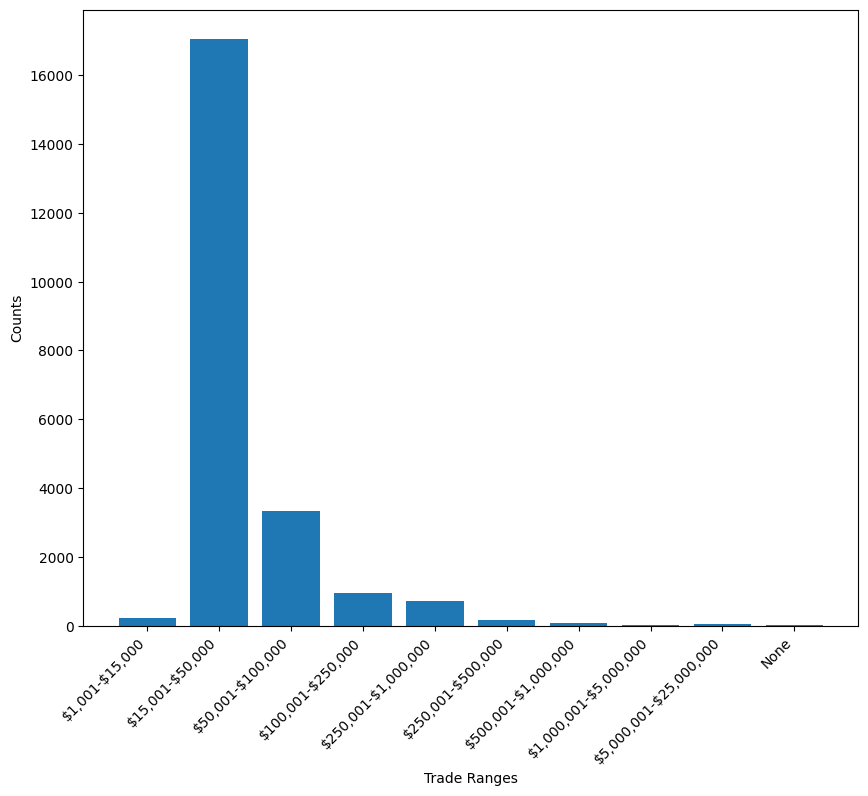

In [10]:
import re

# Group the DataFrame by 'Range' and get the size of each group
range_grouped = congress_trades_df.groupby("Range").size()

# Define a sorting key function
def sort_key(range_str):
    if range_str is None:
        return float('inf')
    if range_str.startswith('>'):
        return float(range_str[1:].replace('$', '').replace(',', '')) + 1
    if range_str.startswith('<'):
        return float(range_str[1:].replace('$', '').replace(',', '')) - 1
    else:
        return float(range_str.split('-')[0].replace('$', '').replace(',', ''))

# Create a list of tuples from the index (range strings) and values (counts)
range_count_tuples = list(zip(range_grouped.index, range_grouped.values))

# Sort the list of tuples by the range strings using the sort_key
sorted_range_count_tuples = sorted(range_count_tuples, key=lambda x: sort_key(x[0]))

# Unpack the sorted tuples back into two lists
sorted_ranges, sorted_counts = zip(*sorted_range_count_tuples)
#format range labels for printing

display_df = pd.DataFrame({
    "TradeRange": sorted_ranges,
    "QuantityTrades": sorted_counts}
    )
print(display_df)

# escape dollar signs so matplotlib does not interpret as begining or ending of latex math
def escape_dollar_signs(input_string):
    return input_string.replace("$", "\$")

def add_commas_to_range(range_string):
    # This function assumes that the range_string is in the format "$number-$number" or "$<number"
    # Extract numbers from the range string
    numbers = re.findall(r'\d+', range_string)
    # Add commas to each number and prepend with a dollar sign
    formatted_numbers = ['$' + format(int(num), ',') for num in numbers]
    # Reconstruct the range string
    if len(formatted_numbers)==2:
        return '-'.join(formatted_numbers)
    if formatted_numbers[0] == "$1,000":
        return f"<{formatted_numbers[0]}"
    

ranges_w_commas = [add_commas_to_range(range) for range in sorted_ranges if range is not None]
formated_and_sorted_ranges = [escape_dollar_signs(range) for range in ranges_w_commas if range is not None]
# add none back in
formated_and_sorted_ranges.append("None")

# Now you can plot using the sorted lists
plt.figure(figsize=(10, 8))
plt.bar(formated_and_sorted_ranges, sorted_counts)
plt.xlabel("Trade Ranges")
plt.ylabel('Counts')
plt.xticks(rotation=45, ha="right")
#plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()





In [11]:
trade_size_df = pd.DataFrame({"TradeQuantity": congress_trades_df.groupby("Range").size() }).reset_index()
print(trade_size_df)

                Range  TradeQuantity
0   $1000001-$5000000             42
1     $100001-$250000            710
2        $1001-$15000          17061
3       $15001-$50000           3326
4    $250001-$1000000            153
5     $250001-$500000             74
6  $5000001-$25000000              5
7    $500001-$1000000             13
8      $50001-$100000            946
9              <$1001            217


In [12]:
# print all transactions greater than 5 mill
whale_trades = congress_trades_df[congress_trades_df["Range"]=='$5000001-$25000000']
print(len(whale_trades))
print(whale_trades)

5
      ReportDate TransactionDate Ticker            name Transaction  \
16887 2020-08-21      2020-07-22    ICE  Kelly Loeffler        Sale   
16889 2020-05-22      2020-05-20    ICE  Kelly Loeffler        Sale   
16891 2020-03-31      2020-03-11    ICE  Kelly Loeffler        Sale   
16892 2020-03-31      2020-03-11    ICE  Kelly Loeffler        Sale   
16895 2020-03-31      2020-02-18    ICE  Kelly Loeffler    Purchase   

          Amount   House               Range TimeToReport  
16887  5000001.0  Senate  $5000001-$25000000      30 days  
16889  5000001.0  Senate  $5000001-$25000000       2 days  
16891  5000001.0  Senate  $5000001-$25000000      20 days  
16892  5000001.0  Senate  $5000001-$25000000      20 days  
16895  5000001.0  Senate  $5000001-$25000000      42 days  


      ReportDate TransactionDate Ticker                name Transaction  \
2006  2022-07-26      2022-07-26   NVDA        Nancy Pelosi        Sale   
2009  2022-07-14      2022-06-17   NVDA        Nancy Pelosi    Purchase   
3555  2021-07-02      2021-06-18  GOOGL        Nancy Pelosi    Exercise   
4256         NaT      2018-06-19      A    Dianne Feinstein    Purchase   
5725  2022-11-30      2022-11-08      V        Nancy Pelosi        Sale   
5729  2022-07-14      2022-06-21      V        Nancy Pelosi        Sale   
7434  2017-11-14      2017-10-18    XON         Mark Warner        Sale   
7651         NaT      2018-06-19    TFX    Dianne Feinstein        Sale   
8384  2019-03-08      2019-02-19   CHTR         Mark Warner        Sale   
9232  2022-03-04      2022-01-21   AAPL        Nancy Pelosi    Exercise   
9234  2022-02-28      2022-01-21   AAPL        Nancy Pelosi    Exercise   
9356  2020-06-09      2020-05-08   AAPL        Nancy Pelosi        Sale   
9385  2020-03-08      202

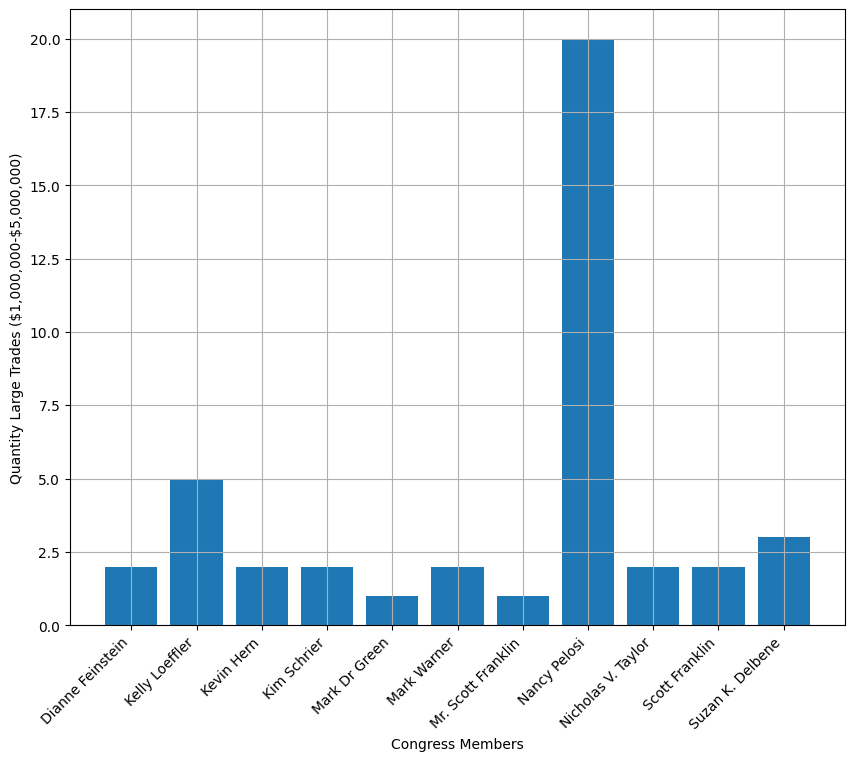

In [13]:
# find all $1,000,000- $5,000,000 transactions
xlarge_trades = congress_trades_df[congress_trades_df["Range"]=='$1000001-$5000000']
print(xlarge_trades)

# plot members and their quanity of large trades
xlarge_trades_group = xlarge_trades.groupby("name").size()

plt.figure(figsize=(10, 8))
plt.bar(xlarge_trades_group.index, xlarge_trades_group)
plt.xlabel("Congress Members")
plt.ylabel("Quantity Large Trades (\$1,000,000-\$5,000,000)")
plt.xticks(rotation=45,ha="right")
plt.grid()
plt.show()



# Calculate Profits per Trade

In [14]:
date = congress_trades_df["TransactionDate"][0]
print(date)

2020-03-18 00:00:00


In [15]:
# # get historical data for all trades in congress trades from first trade to last trade
# headers = (os.getenv("ALPACA_API_KEY_ID"),os.getenv("ALPACA_API_SECRET_KEY"))

# start_date = congress_trades_df["TransactionDate"].min()
# end_date = congress_trades_df["TransactionDate"].min()
# tickers = congress_trades_df["Ticker"].to_list()

# stock_client = StockHistoricalDataClient(*headers)
# stock_split_adjustment = Adjustment.ALL # adjust for stock splits and dividends
# request_params = StockBarsRequest(
#     symbol_or_symbols=tickers[:200],
#     timeframe=TimeFrame.Day,
#     start=start_date,
#     end=end_date,
#     adjustment=stock_split_adjustment
# )

# hist_data_df = stock_client.get_stock_bars(request_params).df
# print(hist_data_df.head())

In [16]:
# use Alpaca to find stock price at transaction date
from dotenv import load_dotenv 
from datetime import timedelta, datetime, date, timezone

load_dotenv()
headers = (os.getenv("ALPACA_API_KEY_ID"),os.getenv("ALPACA_API_SECRET_KEY"))
stock_client = StockHistoricalDataClient(*headers)
stock_split_adjustment = Adjustment.ALL # adjust for stock splits and dividends


def get_midpoint(ticker: str, date: pd._libs.tslibs.timestamps.Timestamp):
    request_params = StockBarsRequest(
        symbol_or_symbols=ticker,
        timeframe=TimeFrame.Day,
        start=date-timedelta(1),
        end=date,
        adjustment=stock_split_adjustment
    )
    # get bars and convert to pandas_df
    df = stock_client.get_stock_bars(request_params).df
    if df.empty:
        print(f"No Result for {ticker}")
        return None
    else:
        midpoint = (df["high"] + df["low"])/2
        print(midpoint)
        return round(midpoint.to_list()[0],2)



# congress_trades_df["trade_price"] = congress_trades_df.apply(lambda row: get_midpoint(row["Ticker"], row["TransactionDate"]),axis=1)
# congress_trades_df.to_csv("../data/congress_trades_transformed_05-01-24.csv",index=False)
# congress_trades_df= pd.read_csv("../data/congress_trades_transformed_05-01-24.csv")

    

In [20]:
# use cache to reduce API calls for trades with identical tickers
cache = {}

def get_current_price(ticker):
    if ticker not in cache.keys():
        cache[ticker] = get_midpoint(ticker, datetime.now())
    return cache[ticker]

# free ALPACA subscription does not allow for querying data within past 15 minutes
# must explicitly specify a timestamp which is 15 minutes before current time


# congress_trades_df["current_price"] = congress_trades_df.apply(lambda row: get_current_price(row["Ticker"]),axis=1)
# congress_trades_df.to_csv("/Users/austinpaxton/Documents/dev/AI/congress_trades/data/congress_trades_transformed_05-03-24.csv",index=False)
congress_trades_df = pd.read_csv("../data/congress_trades_transformed_05-03-24.csv")


In [73]:
congress_trades_df = pd.read_csv("../data/congress_trades_transformed_05-03-24.csv")

In [74]:
congress_trades_df.info()
# remove values where current price and or trade price not available
congress_trades_df = congress_trades_df[(congress_trades_df["trade_price"].notnull()) & (congress_trades_df["current_price"].notnull())]
congress_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22620 entries, 0 to 22619
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ReportDate       22261 non-null  object 
 1   TransactionDate  22620 non-null  object 
 2   Ticker           22620 non-null  object 
 3   name             22620 non-null  object 
 4   Transaction      22620 non-null  object 
 5   Amount           22620 non-null  float64
 6   House            22620 non-null  object 
 7   Range            22547 non-null  object 
 8   TimeToReport     22261 non-null  object 
 9   trade_price      21909 non-null  float64
 10  current_price    20217 non-null  float64
dtypes: float64(3), object(8)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 20057 entries, 0 to 22619
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ReportDate       19791 non-null  object 

In [76]:
congress_trades_df.head()

,ReportDate,TransactionDate,Ticker,name,Transaction,Amount,House,Range,TimeToReport,trade_price,current_price
0,2020-04-16,2020-03-18,COTY,Gilbert Cisneros,Sale,1001.0,Representatives,$1001-$15000,29 days,4.035,11.62
1,2020-01-10,2019-12-06,COTY,Gilbert Cisneros,Purchase,1001.0,Representatives,$1001-$15000,35 days,11.795,11.62
2,2019-09-11,2019-08-14,COTY,Gilbert Cisneros,Sale,1001.0,Representatives,$1001-$15000,28 days,9.134,11.62
3,2019-09-16,2019-08-13,COTY,Dean Phillips,Sale,1001.0,Representatives,$1001-$15000,34 days,9.504,11.62
4,2019-04-16,2019-03-14,COTY,Gilbert Cisneros,Purchase,1001.0,Representatives,$1001-$15000,33 days,10.510,11.62


## Calculate Profits

In order to calculate profits, we must make assumptions. 

- Issue:
    * The congressional trades are taken from a fixed date window from 2014-07-25 to 2023-03-03 
        * Due to this window, we do not have all trades for each Senator

- Assumption: 
    * Assume that congress members are not short selling. 
        * This accounts for the edge case where the congress memeber bought shares before our window and sold inside the window
- Implementation:
    * If the shares sold for a sale transaction brings total shares to negative, the shares_owned will become 0 not negative. 
        * Profit for the trade will be calculated using the current cost basis

In [77]:

def date_diff_in_years(date_initial: str, date_final: str):
    # Parse the date strings into datetime objects
    # if type()
    date1 = datetime.strptime(date_initial, "%Y-%m-%d")
    date2 = datetime.strptime(date_final, "%Y-%m-%d")

    # Calculate the difference between the dates
    difference = date2 - date1

    # Convert difference in days to years
    years_difference = (
        difference.days / 365.25
    )  # Using 365.25 to account for leap years

    return years_difference


def time_interval_to_normalize_realized(df, date_key="TransactionDate"):
    """
    Use time interval between first purchase and last sale
    """
    first_purchase = df[df["Transaction"] == "Purchase"]["TransactionDate"].min()
    last_sale = df[df["Transaction"] == "Sale"]["TransactionDate"].max()
    return date_diff_in_years(first_purchase, last_sale)


def time_interval_to_normalize_unrealized(
    df, date_key="TransactionDate", current_price_date="2024-05-03"
):
    """
    Use time interval between first purchase and date of current_price (2024-05-03)
    """
    first_purchase = df[df["Transaction"] == "Purchase"]["TransactionDate"].min()
    return date_diff_in_years(first_purchase, current_price_date)


def calc_gains(group):
    group = group.sort_values(["TransactionDate"])
    percent_gain_realized = []
    realized_percent_gain_weighted = None
    realized_gains_per_year = None
    unrealized_percent_gains = None
    unrealized_gains_per_year = None
    total_cost = 0
    cost_basis = 0
    total_value = 0
    shares_owned = [0]
    shares_sold = []
    for i, trade in enumerate(group.iterrows()):
        trade = trade[1]
        if trade["Transaction"] == "Purchase":
            total_value += trade["Amount"]
            total_cost += trade["Amount"] * trade["trade_price"]
            cost_basis = total_cost / total_value
            shares_owned.append(
                trade["Amount"] / trade["trade_price"] + shares_owned[-1]
            )

        if trade["Transaction"] == "Sale" and shares_owned[-1] != 0:
            r_gain = round(100 * (trade["trade_price"] - cost_basis) / cost_basis, 2)
            pending_shares_sold = trade["Amount"] / trade["trade_price"]
            pending_shares_owned = shares_owned[-1] - pending_shares_sold
            # dont allow short selling enforce shares_owned cant be negative
            if pending_shares_owned <= 0:
                # sell all of shares owned
                pending_shares_sold = shares_owned[-1]
                # update shares owned to 0
                pending_shares_owned = 0
                total_value = 0
                total_cost = 0

            shares_sold.append(pending_shares_sold)
            shares_owned.append(pending_shares_owned)

            percent_gain_realized.append(r_gain)
        if (
            i == len(group) - 1 and shares_owned[-1] != 0
        ):  # calculate unrealized profits on shares owned
            unrealized_percent_gains = round(
                100 * (trade["current_price"] - cost_basis) / cost_basis, 2
            )

            unrealized_gains_per_year = (
                unrealized_percent_gains / time_interval_to_normalize_unrealized(group)
            )

    # calculate realized percent gain weighted by number of shares sold
    if shares_sold != []:
        realized_percent_gain_weighted = round(
            sum(np.array(shares_sold) * np.array(percent_gain_realized))
            / sum(np.array(shares_sold)),
            2,
        )
        realized_gains_per_year = (
            realized_percent_gain_weighted / time_interval_to_normalize_realized(group)
        )

    return (
        realized_percent_gain_weighted,
        unrealized_percent_gains,
        realized_gains_per_year,
        unrealized_gains_per_year,
    )

In [78]:
grouped_trades = congress_trades_df.groupby(["name","Ticker"])
# print(grouped_trades.indices),axis=1


In [80]:
columns = ["name", "Ticker", "realized_gain", "unrealized_gain", "realized_gain_per_year", "unrealized_gain_per_year"]
trade_results = []
for group in grouped_trades:
    trades = group[1]
    trade_results.append(group[0] + calc_gains(trades))

results_df = pd.DataFrame(trade_results, columns=columns)
results_df.to_csv("../data/congress_trade_results_05-03-24.csv", index=False)

/var/folders/hn/vdq8ffhj0zq9blr74w80pr180000gn/T/ipykernel_1746/268313258.py:95: RuntimeWarning: invalid value encountered in scalar divide
  realized_percent_gain_weighted / time_interval_to_normalize_realized(group)


In [81]:
display(results_df.head())
display(results_df.describe())
display(results_df.info())

,name,Ticker,realized_gain,unrealized_gain,realized_gain_per_year,unrealized_gain_per_year
0,A. Mitchell Jr. McConnell,IR,NaN,NaN,NaN,NaN
1,A. Mitchell Jr. McConnell,KR,NaN,14.19,NaN,9.947980
2,A. Mitchell Jr. McConnell,WFC,NaN,45.79,NaN,6.882633
3,Abigail Spanberger,LHX,NaN,NaN,NaN,NaN
4,Adam B. Schiff,ABBV,NaN,NaN,NaN,NaN


,realized_gain,unrealized_gain,realized_gain_per_year,unrealized_gain_per_year
count,2531.000000,3117.000000,2518.000000,3117.000000
mean,9.122438,68.626901,7.727500,15.414948
std,35.537680,144.487652,285.281532,29.398308
min,-93.910000,-99.380000,-1961.392500,-66.845535
25%,-7.975000,3.740000,-14.127610,1.121179
50%,2.730000,39.210000,4.002698,10.281608
75%,18.675000,95.840000,22.753245,22.222271
max,300.600000,4121.030000,13313.362500,494.970802


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      6456 non-null   object 
 1   Ticker                    6456 non-null   object 
 2   realized_gain             2531 non-null   float64
 3   unrealized_gain           3117 non-null   float64
 4   realized_gain_per_year    2518 non-null   float64
 5   unrealized_gain_per_year  3117 non-null   float64
dtypes: float64(4), object(2)
memory usage: 302.8+ KB


None

In [70]:
results_df[results_df["unrealized_gain"]==4121.030000]
congress_trades_df[(congress_trades_df["name"]=="Sheldon Whitehouse") & (congress_trades_df["Ticker"]=="NVDA")]

,ReportDate,TransactionDate,Ticker,name,Transaction,Amount,House,Range,TimeToReport,trade_price,current_price
2164,2019-06-11,2019-05-17,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,25 days,39.5600,881.61
2168,2019-01-10,2018-12-28,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,13 days,33.2000,881.61
2169,2018-11-15,2018-10-23,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,23 days,54.6250,881.61
2173,2018-03-07,2018-02-16,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,19 days,61.0300,881.61
2182,2017-02-14,2017-01-11,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,34 days,25.9150,881.61
2183,2016-06-16,2016-05-18,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,29 days,10.5150,881.61
2184,2016-05-23,2016-04-26,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,27 days,8.9915,881.61
2185,2017-08-10,2016-04-26,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,471 days,8.9915,881.61
2186,2017-08-10,2016-04-19,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,478 days,8.9735,881.61
2187,2016-05-23,2016-04-19,NVDA,Sheldon Whitehouse,Purchase,1001.0,Senate,$1001-$15000,34 days,8.9735,881.61
